# Importy i konfiguracja
W tej sekcji importujemy potrzebne biblioteki oraz ustawiamy ziarno losowości,
aby wyniki były powtarzalne.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

np.random.seed(42)


# Funkcja pomocnicza do pomiaru czasu
Funkcja `measure_time` mierzy czas wykonania dowolnej funkcji wraz z argumentami.
Zwraca czas wykonywania funkcji (w milisekundach). 

In [6]:
def measure_time(func, *args, repetitions=10):
    times = []
    for _ in range(repetitions):
        start = time.perf_counter()
        func(*args)
        end = time.perf_counter()
        times.append((end - start) * 1e3)
    return times


# Definicje operacji
W tej sekcji definiujemy dwie funkcje:  
    - `generalized_dot`: uogólniony iloczyn skalarny, czyli dot (x, A, y)  
    - `matrix_vector`: mnożenie macierzy A przez wektor x  
Obie operacje mają złożoność O(n^2) dla macierzy pełnej.


In [7]:
def generalized_dot(A, x, y):
    return np.dot(x, np.dot(A, y))

def matrix_vector(A, x):
    return np.dot(A, x)

# Funkcja pomocnicza usuwająca wartości odstające.
Wykonując to ćwiczenie zaobserwowałem, ze w wynikach pojawiają się wartości czasowe, 
które w bardzo znaczący sposób odbiegają od pozostałych, zaburzając wykres. 
Niestety, pomiar czasu działania takiej funkcji zalezy od wielu czynników. 
Zdecydowałem się więc na pomocniczą funkcję, która usunie 30% pomiarów o najbardziej odstających wartościach.
W ten sposób, otrzymane przez nas wyniki będą bardziej wiarygodne.
Wykonanie tej funkcji nie zostało ujęte w poleceniu, ale uwazam, ze jest wartościowa.
Problem najprawdopodobniej związany jest z wykorzystywanym przeze mnie systemem MacOS.



In [8]:
def remove_extremes(data, percentage):
    """
    Usuwa określony procent danych (o największym odchyleniu od mediany).
    """
    n = data.shape[0]
    if n <= 3 or percentage <= 0:
        return data
    n_remove = int(np.ceil(n * percentage))
    if n_remove >= n:
        return np.array([])
    median = np.median(data)
    deviations = np.abs(data - median)
    # Sortujemy indeksy według rosnących odchyleń
    sorted_indices = np.argsort(deviations)
    # Zachowujemy wszystkie elementy poza tymi o największym odchyleniu
    filtered_data = data[sorted_indices[:-n_remove]]
    return filtered_data

# Pomiary czasów i zapis wyników do CSV
W tej części generujemy dane (macierz A, wektory x i y) dla rozmiarów od 1000
do 10000 (co 200) oraz wykonujemy 30 pomiarów dla każdej operacji. Odsiewamy 30% najbardziej odstających wartości.
Zdecydowałem się zmodyfikować liczbę pomiarów względem polecenia (z 10 na 30), poniewaz zaobserwowałem duze wahania wyników, co wynika najprawdopodobniej z działania systemu macOS.
Wyniki zapisujemy do jednego pliku CSV.

In [9]:
# Parametry pomiaru
n_sizes = list(range(1000, 10000, 100))
n_trials = 30
removal_percentage = 0.3

results = []
for n in n_sizes:
    # Generujemy dane: macierz A (n x n) oraz wektory x i y (długość n)
    A = np.random.rand(n, n)
    x = np.random.rand(n)
    y = np.random.rand(n)
    
    # Pomiary dla uogólnionego iloczynu skalarnego
    times_dot = np.array(measure_time(generalized_dot, A, x, y, repetitions=n_trials))
    times_dot_filtered = remove_extremes(times_dot, removal_percentage)
    for t in times_dot_filtered:
        results.append({
            "operation": "generalized_dot",
            "n": n,
            "time_milisec": t
        })
    
    # Pomiary dla mnożenia macierzy przez wektor
    times_mv = np.array(measure_time(matrix_vector, A, x, repetitions=n_trials))
    times_mv_filtered = remove_extremes(times_mv, removal_percentage)
    for t in times_mv_filtered:
        results.append({
            "operation": "matrix_vector",
            "n": n,
            "time_milisec": t
        })

# Konwersja wyników do DataFrame i zapis do pliku CSV
df_results = pd.DataFrame(results)
display(df_results)

csv_filename = "wyniki_pomiarow.csv"
df_results.to_csv(csv_filename, index=False)
print(f"Wyniki zapisano do pliku: {csv_filename}")

,operation,n,time_milisec
0,generalized_dot,1000,0.033875
1,generalized_dot,1000,0.033916
2,generalized_dot,1000,0.033916
3,generalized_dot,1000,0.033875
4,generalized_dot,1000,0.033834
...,...,...,...
3775,matrix_vector,9900,12.727167
3776,matrix_vector,9900,12.721750
3777,matrix_vector,9900,12.961708
3778,matrix_vector,9900,12.709458


Wyniki zapisano do pliku: wyniki_pomiarow.csv


# Analiza wyników i wykresy
W tej sekcji wczytujemy dane z CSV, obliczamy średni czas wykonania oraz 
odchylenie standardowe dla każdej operacji i rozmiaru, a następnie rysujemy wykresy
z error barami dla uogólnionego iloczynu skalarnego oraz mnożenia macierzy przez wektor.


,operation,n,mean,std
0,generalized_dot,1000,0.032752,0.001682
1,generalized_dot,1100,0.047802,0.008679
2,generalized_dot,1200,0.049196,0.000900
3,generalized_dot,1300,0.066445,0.005225
4,generalized_dot,1400,0.098732,0.009426
...,...,...,...,...
175,matrix_vector,9500,14.591125,0.036476
176,matrix_vector,9600,12.453175,0.028448
177,matrix_vector,9700,12.011816,0.037270
178,matrix_vector,9800,14.516071,0.207655


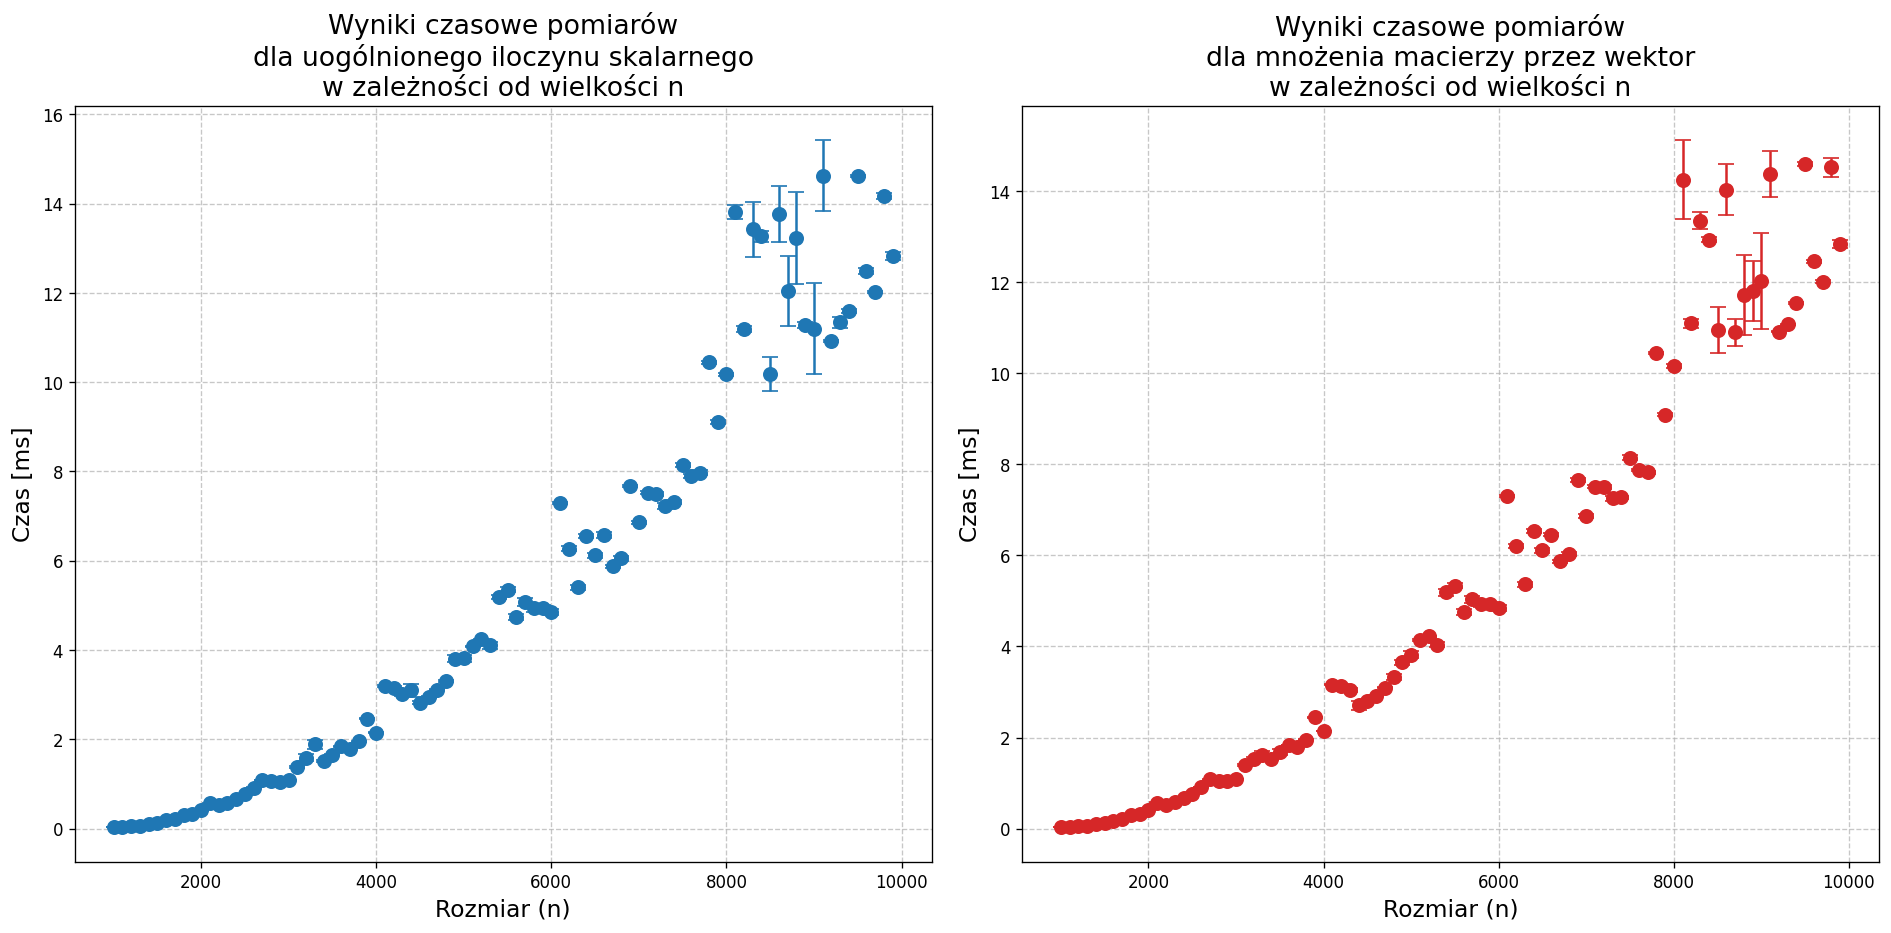

In [10]:

df = pd.read_csv(csv_filename)

# Grupowanie danych: obliczamy średnią (mean) oraz odchylenie standardowe (std)
stats = df.groupby(["operation", "n"])["time_milisec"].agg(["mean", "std"]).reset_index()
display(stats)

dot_stats = stats[stats["operation"] == "generalized_dot"]
mv_stats = stats[stats["operation"] == "matrix_vector"]

fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=120)

plt.rcParams.update({'font.size': 14})

# Wykres dla uogólnionego iloczynu skalarnego
axs[0].errorbar(dot_stats["n"], dot_stats["mean"], yerr=dot_stats["std"],
                fmt='o', capsize=5, markersize=8, color='tab:blue', linestyle='none')
axs[0].set_title("Wyniki czasowe pomiarów\n"
                 "dla uogólnionego iloczynu skalarnego\n"
                 "w zależności od wielkości n", fontsize=16)
axs[0].set_xlabel("Rozmiar (n)", fontsize=14)
axs[0].set_ylabel("Czas [ms]", fontsize=14)
axs[0].grid(True, which='both', linestyle='--', alpha=0.7)

# Wykres dla mnożenia macierzy przez wektor
axs[1].errorbar(mv_stats["n"], mv_stats["mean"], yerr=mv_stats["std"],
                fmt='o', capsize=5, markersize=8, color='tab:red', linestyle='none')
axs[1].set_title("Wyniki czasowe pomiarów\n"
                 "dla mnożenia macierzy przez wektor\n"
                 "w zależności od wielkości n", fontsize=16)
axs[1].set_xlabel("Rozmiar (n)", fontsize=14)
axs[1].set_ylabel("Czas [ms]", fontsize=14)
axs[1].grid(True, which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()